# Discrete Cosine Transform
Its all about compression - that led to MP3 and JPEG

While the topic of `compression` forms a very small part of this notebook, the primary objective is to understand the need for DCT in 1D signals. 

## Synthesize A Signal
We will start by synthesizing a signal using known amplitudes. Thereafter, we will see how DCT helps us to reveal the amplitude of a signal whose amplitude for each frequency component is unknown. 

In [60]:
t = 1
framerate = 11025
ts = np.linspace(0,t,framerate)
fs = np.array([100, 200, 300, 400])
amps = np.array([0.6, 0.25, 0.1, 0.05])

In [61]:
def synthesize2(amps, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(2*np.pi*args)
    ys = np.dot(M, amps.T) # (ts x 4 4 x 1 = ts X 1)
    return ys  

In [62]:
wave2 = synthesize2(amps, fs, ts)

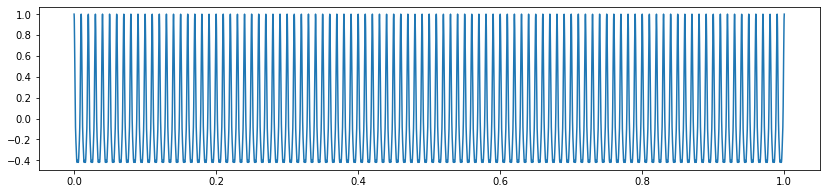

In [63]:
fig, ax = plt.subplots(1,1, figsize=(14,3))
ax.plot(ts,wave2)

In [73]:
# requires investigation as to why this difference is high?
max(abs(wave1-wave2))

1.4

## Analysis
Given a wave which is composed of the sum of cosines with a given set of frequencies. How would we ﬁnd the amplitude for each frequency component? In other words, given `ys`, `ts` and `fs`, can we recover `amps`?

Mathematically, we can use `ys`, `ts` and `fs` to compute, `M = cos(2*pi*f*t)`. Then we want to find `a` such that `y = Ma`.

In [64]:
def analyze1(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(2*np.pi * args)
    amps = np.linalg.solve(M, ys)
    return amps

But there’s a catch. In general we can only solve a system of linear equations if the matrix is square; that is, the number of equations (rows) is the same as the number of unknowns (columns).

In this example, we have only `4` frequencies, but we evaluated the signal at `11,025` times. So we have many more equations than unknowns.

![A matrix](images/matrix.png)

For simplicity, lets use first `4` values of `t` and `y` (so that we match it with `fs`) and try to evaluate amps

In [65]:
# 
n = len(fs)
amps2 = analyze1(wave2[:n], fs, ts[:n])
print(amps2)

[0.6  0.25 0.1  0.05]


In [66]:
# amps and amps2 are an exact match, as expected
amps

array([0.6 , 0.25, 0.1 , 0.05])

Solving a linear system of equations takes time proportional to $n^3$, where `n` is the number of columns in `M`. We can do better.

## Orthogonal Matrices

We are aware that, 

$$y = Ma$$

We can mutiply both side by $M^{-1}$, which yields, 

$$M^{-1}y = M^{-1}Ma$$

Therefore, 
$$M^{-1}y = a$$ or 
$$a = M^{-1}y$$

Computing, $M^{-1}$ takes $n^2$ time. Furthermore, if $M$ is **orthogonal**, $M^{-1} = M^{T}$. It implies that, $$M^TM = I$$.

We can check if a matrix is orthogonal, by checking if $M^TM = I$

In NumPy transposing an array is a constant-time operation. It doesn’t actually move the elements of the array; instead, it creates a "view" that changes the way the elements are accessed.

In the previous example, `M` had 11,025 rows, so it might be a good idea to work with a smaller example:

In [67]:
# In test1(), we have four values of fs and ts, respectively. 
def test1():
    amps = np.array([0.6, 0.25, 0.1, 0.05])
    N = 4.0 # number of samples
    ts = np.arange(N) / N  # N equally spaced values from 0 to time_unit. time_unit = 1
    print("Time Vector = {}".format(ts))
    fs = np.arange(N) / 2  # frequencies = samples/sampling_resolution
    print("Frequency Vector = {}".format(fs))
    
    # code to synthesize
    args = np.outer(ts, fs)
    M = np.cos(2*np.pi*args)
    ys = np.dot(M, amps.T) # (ts x 4 4 x 1 = ts X 1)
    return ys, M

In [68]:
ys, matrix = test1()
print("ts x fs matrix follows\n\n{}".format(matrix))

Time Vector = [0.   0.25 0.5  0.75]
Frequency Vector = [0.  0.5 1.  1.5]
ts x fs matrix follows

[[ 1.    1.    1.    1.  ]
 [ 1.    0.71  0.   -0.71]
 [ 1.    0.   -1.   -0.  ]
 [ 1.   -0.71 -0.    0.71]]


Observe that the above matrix is symmetric, which implies at $M^T = M$. Perhaps, our choice of `ts` and `fs` made it symmetric. Lets check if $M^TM = I$?

In [69]:
np.dot(matrix.T, matrix)

array([[ 4.,  1., -0.,  1.],
       [ 1.,  2.,  1., -0.],
       [-0.,  1.,  2.,  1.],
       [ 1., -0.,  1.,  2.]])

Unfortunately, this is not an identity matrix, which means that it is not orthogonal

In [70]:
# but we do get our amplitude, becuase the M matrix is square.
np.linalg.solve(matrix, ys)

array([0.6 , 0.25, 0.1 , 0.05])

## DCT-IV

**But if we choose ts and fs carefully, we can make M orthogonal.**

One simple option is to shift `ts` and `fs` by a half unit. This version is called **DCT-IV**, where "IV" is a roman numeral indicating that this is the fourth of eight versions of the DCT.

In [32]:
def test2():
    N = 4.0
    ts = (0.5 + np.arange(N)) / N
    fs = (0.5 + np.arange(N)) / 2.0
    
    # code to synthesize
    args = np.outer(ts, fs)
    M = np.cos(2*np.pi*args)
    return M

In [71]:
M = test2()
print("ts x fs matrix follows\n\n{}".format(M))

ts x fs matrix follows

[[ 0.98  0.83  0.56  0.2 ]
 [ 0.83 -0.2  -0.98 -0.56]
 [ 0.56 -0.98  0.2   0.83]
 [ 0.2  -0.56  0.83 -0.98]]


In [72]:
M.transpose().dot(M)

array([[ 2.,  0.,  0.,  0.],
       [ 0.,  2., -0., -0.],
       [ 0., -0.,  2., -0.],
       [ 0., -0., -0.,  2.]])

In [73]:
# or
np.dot(M.T, M)

array([[ 2.,  0.,  0.,  0.],
       [ 0.,  2., -0., -0.],
       [ 0., -0.,  2., -0.],
       [ 0., -0., -0.,  2.]])

The above matrix is close to being the Identity matrix with diagonal elements as `2`

In [74]:
# extract original amplitudes using linear algebra - Costly operation
print(np.linalg.solve(matrix, ys))

[0.6  0.25 0.1  0.05]


Because $M$ is symmetric, $M^T = M$. Because it is orthogonal, $M^{-1} = M^{T}$ or, in this case, $M^{-1} = M$. But the $I$ matrix has a factor of $2$. Therefore, the inverse of $M$ is just $\frac{M}{2}$. Now we can write a more eﬃcient version of extracting the ampltude.

**Old Method**
```old
def analyze1(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(2*np.pi * args)
    amps = np.linalg.solve(M, ys)
    return amps
```

Recall that, $a = M^{-1}y$. Our choice of `ts` and `fs`, converts this to $a = \frac{My}{2}$

**New Method**
```
def analyze2(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(2*np.pi * args)
    amps = np.dot(M, ys) / 2
    return amps
```

In [76]:
def analyze2(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(2*np.pi * args)
    amps = np.dot(M, ys) / 2
    return amps

In [77]:
# we can write a dct_iv function that choses the value of fs and ts to find amps
def dct_iv(ys):
    N = len(ys)
    ts = (0.5 + np.arange(N)) / N
    fs = (0.5 + np.arange(N)) / 2
    args = np.outer(ts, fs)
    M = np.cos(2*np.pi * args)
    amps = np.dot(M, ys) / 2
    return amps

In [78]:
amps = np.array([0.6, 0.25, 0.1, 0.05])
N = 4.0
ts = (0.5 + np.arange(N)) / N
fs = (0.5 + np.arange(N)) / 2
ys = synthesize2(amps, fs, ts)
amps2 = dct_iv(ys)
amps = analyze1(ys, fs, ts)
max(abs(amps - amps2))

8.326672684688674e-17

Observe that the difference between actual amplitude and estimated amplitude is very very small in the oreder of $10^{-17}$

## Inverse DCT

Our function `synthesize2()` and `analyze2()` are almost identical. The only diﬀerence is that `analyze2()` divides the result by 2. We can use this insight to compute the inverse DCT.

```
def synthesize2(amps, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(2*np.pi*args)
    ys = np.dot(M, amps.T) #(ts x 4 4 x 1 = ts X 1)
    return ys  
```
For appropriately chosen `fs` and `ts`, 
```
def analyze2(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(2*np.pi * args)
    amps = np.dot(M, ys) / 2
    return amps
```

In [79]:
# dct_iv: Given a signal, find its amplitude.
# inverse_dc_iv: Given amplitude, compute the signal
def inverse_dct_iv(amps):
    return dct_iv(amps) * 2

In [80]:
amps = [0.6, 0.25, 0.1, 0.05]
ys = inverse_dct_iv(amps)
amps2 = dct_iv(ys)
max(abs(amps - amps2))

5.551115123125783e-17

## Now, we know all the concepts required to develop the final DCT function. 
We will develop a triangle wave, and use DCT to compute the amplitudes correspoding to frequencies

In [156]:
def unbias(ys):
    """Shifts a wave array so it has mean 0.

    ys: wave array

    returns: wave array
    """
    return ys - ys.mean()

def normalize(ys, amp=1.0):
    """Normalizes a wave array so the maximum amplitude is +amp or -amp.

    ys: wave array
    amp: max amplitude (pos or neg) in result

    returns: wave array
    """
    high, low = abs(max(ys)), abs(min(ys))
    return amp * ys / max(high, low)

def triangleSignal(freq, duration, framerate, offset):
    amp = 1
    n = round(duration * framerate)
    ts = np.arange(n) / framerate
    ts = np.asarray(ts)
    cycles = freq * ts + offset / (2*np.pi)
    frac, _ = np.modf(cycles)
    ys = np.abs(frac - 0.5)
    ys = normalize(unbias(ys), amp)
    return ys, ts

import scipy.fftpack
def make_dct(ys):
    """Computes the DCT of this wave."""
    N = len(ys)
    hs = scipy.fftpack.dct(ys, type=2) #we are using DCT Type II instead of IV
    fs = (0.5 + np.arange(N)) / 2
    return hs, fs

(0.0, 0.1)

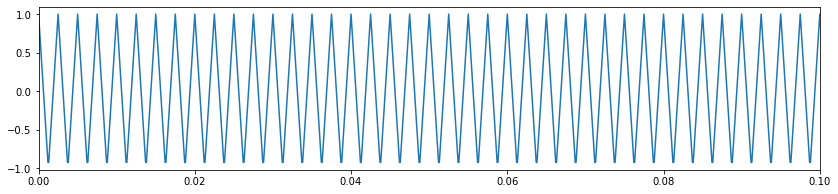

In [103]:
ys, ts = triangleSignal(400, 1.0, 10000, 0)
fig, ax = plt.subplots(1,1, figsize=(14,3))
ax.plot(ts,ys)
ax.set_xlim(0.0, 0.1)

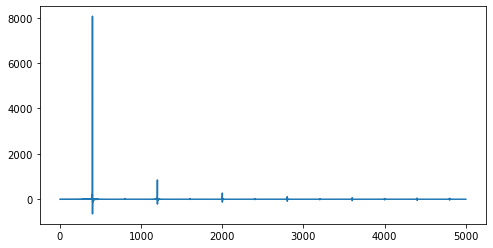

In [107]:
hs, fs = make_dct(ys)
fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.plot(fs,hs)

In [110]:
# The highest frequency is at
fs[np.argmax(hs)]

400.25

## DCT For Compression

One of the major applications of the DCT is compression for both sound and images. In its simplest form, DCT-based compression works like this:

1. Break a long signal into segments.
2. Compute the DCT of each segment.
3. Identify frequency components with amplitudes so low they are inaudible, and remove them. Store only the frequencies and amplitudes that remain.
4. To play back the signal, load the frequencies and amplitudes for each segment and apply the inverse DCT.


In [176]:
import librosa
from IPython.display import Audio

We will use librosa to load a audio file.

In [177]:
ys, sr = librosa.load("100475__iluppai__saxophone-weep.wav", sr=44100)
audio = Audio(data=ys, rate=sr)
audio

For sake of understanding, we extract out a segment of the audio. We apply DCT on this segment to view the amplitude of frequencies

(0.0, 4500.0)

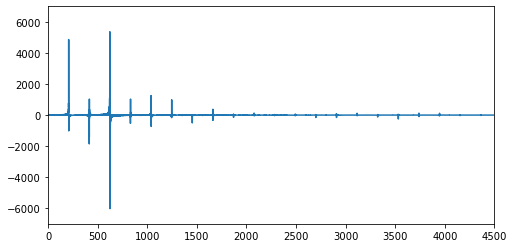

In [178]:
# get a segment of the audio and normalise it
start=1.2
duration=0.5
segment_ys = ys[int(start*sr): int((start+duration)*sr)+1]
segment_ys = normalize(segment_ys, amp=1.0)
    
# perform dct and view the dct
hs, fs = make_dct(segment_ys)
fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.plot(fs,hs)
ax.set_ylim(-7000,7000)
ax.set_xlim(0, 4500)

In [179]:
# let us hear the segment so that we can later compare this to the compressed version of the segment.
original_segment_ys = make_wave_from_dct(hs)
audio = Audio(data=original_segment_ys, rate=sr)
audio

There are only a few harmonics with substantial amplitude, and many entries near zero. The following function takes a DCT and sets elements below thresh to 0.

In [180]:
def compress(hs, thresh=1):
    count = 0
    for i, amp in enumerate(hs):
        if np.abs(amp) < thresh:
            hs[i] = 0
            count += 1
            
    n = len(hs)
    print(count, n, 100 * count / n, sep='\t')
    return hs

20476	22051	92.85746678155186


(0.0, 4500.0)

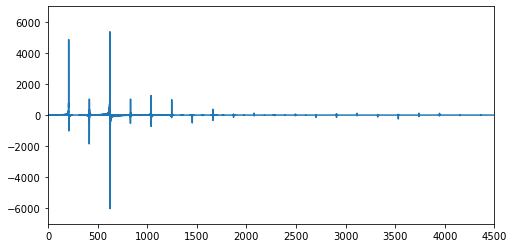

In [181]:
hs,_ = make_dct(segment_ys)
compressed_hs = compress(hs, thresh=10)
fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.plot(fs,compressed_hs)
ax.set_ylim(-7000,7000)
ax.set_xlim(0, 4500)

With our compression, we eliminated more than **90%** of the elements

Next, we use inverse dct to get back the audio signal from its DCT. 

In [182]:
# now we use inverse dct to get back the audio signal from its DCT
def make_wave_from_dct(hs):
    """Transforms to the time domain.

    returns: Wave
    """
    N = len(hs)
    ys = scipy.fftpack.idct(hs, type=2) / 2 / N
    # NOTE: whatever the start time was, we lose it when
    # we transform back
    # ts = self.start + np.arange(len(ys)) / self.framerate
    return ys

Playing this wave sounds similar to the original segment that we extracted. Mission accomplished! Since 92% of the entries are zero in this segment, we will save a significant amount of memory while saving this segment compared to the original segment

In [183]:
restored_segment_ys = make_wave_from_dct(hs)
audio = Audio(data=restored_segment_ys, rate=sr)
audio